we have already seen and implemented a basic agent in tool_calls file

## ReAct (General Agent Architecture)
- **Act:** the model calls specific tool binded with llm or end the conversation based on user input
- **Observe:** once the tools execute and provided the output, it will not end the conversation instead it will passes the tool response output back to the llm model
- **Reason:** based on the output response from the tool and user input, the model will decide what to do in the next step

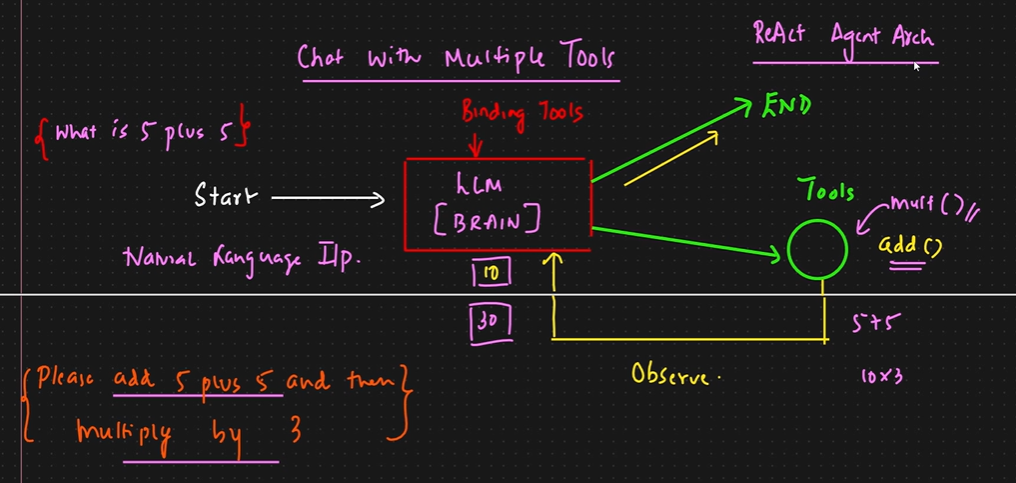

A ReAct agent is a more advanced type of LLM agent that integrates a "reasoning" step with an "acting" step in a continuous loop. While a basic agent can use tools to perform actions and get results, a ReAct agent is designed to think step-by-step before it acts. This allows it to break down complex problems, adjust its plan based on observations, and self-correct when something goes wrong.

The key advantage of a ReAct agent is that it combines the reasoning capabilities of a Large Language Model (LLM) with the ability to interact with external tools and environments. This results in a more robust and capable system that can handle complex, multi-step tasks.

##### How a ReAct Agent Works
Unlike a basic agent that might simply execute a tool based on a direct prompt, a ReAct agent follows an iterative cycle:
- **Thought:** The agent first generates a thought, or a step-by-step reasoning process, to analyze the problem and formulate a plan. It will determine what needs to be done and which tools are best suited for the task.
- **Action:** Based on its thought process, the agent executes an action by calling an external tool, like a search engine or a calculator.
- **Observation:** After the action is executed, the agent observes the result from the tool.
- **Re-Evaluation:** The agent then uses this new observation to inform its next "Thought" step. It evaluates whether the result was successful or if the plan needs to be adjusted.

This cycle continues until the agent concludes that it has the final answer. This "thought-action-observation" loop allows ReAct to handle uncertainty and dynamic environments better than a basic agent.

In [4]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

arxiv_wrapper=ArxivAPIWrapper()
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)
arxiv.invoke('attention is all you need')

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [5]:
wiki_wrapper=WikipediaAPIWrapper()
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper)
wiki.invoke('tom and jerry')

"Page: Tom and Jerry\nSummary: Tom and Jerry (also alternately stylized as Tom & Jerry) is an American animated media franchise and series of comedy short films created in 1940 by William Hanna and Joseph Barbera. Best known for its 161 theatrical short films by Metro-Goldwyn-Mayer, the series centers on the enmity between the titular characters of a cat named Tom and a mouse named Jerry. Many shorts also feature several recurring characters.\nCreated in 1940 when the MGM cartoon studio was struggling to compete with Walt Disney Productions and Leon Schlesinger Productions, Tom and Jerry's initial short film titled Puss Gets the Boot proved successful in theaters and garnered an Academy Award nomination for Best Short Subject (Cartoon). Hanna and Barbera later directed a total of 114 Tom and Jerry shorts for its initial MGM run from 1940 to 1958. During this time, they won seven Academy Awards for Best Animated Short Film, tying for first place with Walt Disney's Silly Symphonies with 

In [6]:
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY']=os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACKING_V2']='true'
os.environ['LANGCHAIN_PROJECT']='ReAct-agent'

NOTE: we need to make sure that the docstring which we are providing in custom tools must follow the standard with proper space, line break else it will throw error

In [7]:
# custom tools

def add(a:int,b:int)->int:
    """Add a and b.

    Args:
        a: first int
        b: second int

    Returns:
        int
    """
    return a+b

def sub(a:int,b:int)->int:
    """Subtract a and b.

    Args:
        a: first int
        b: second int

    Returns:
        int
    """
    return a-b

def multiply(a:int,b:int)->int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int

    Returns:
        int
    """
    return a*b

def divide(a:int,b:int)->float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
        
    Returns:
        float
    """
    return a/b

In [8]:
tools=[arxiv,wiki,add,sub,multiply,divide]

In [9]:
from langchain_groq import ChatGroq

groq_llm=ChatGroq(model='llama-3.1-8b-instant')

groq_with_tools=groq_llm.bind_tools(tools)

groq_with_tools.invoke('2 plus 2 multiply 3').tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'jrtxd96m5',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 2, 'b': 6},
  'id': 'nt72677t1',
  'type': 'tool_call'}]

In [10]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [11]:
def llm_node(state:State):
    return {'messages':[groq_with_tools.invoke(state['messages'])]}

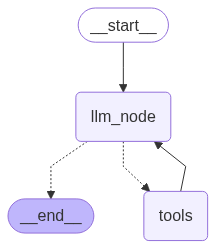

In [12]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image
from langgraph.prebuilt import ToolNode,tools_condition

graph=StateGraph(State)
graph.add_node('llm_node',llm_node)
graph.add_node('tools',ToolNode(tools))

graph.add_edge(START,'llm_node')
# graph.add_edge('llm_node',END) # here we can skip this
graph.add_conditional_edges('llm_node',tools_condition)
# edge from tools to perform observe 
graph.add_edge('tools','llm_node')

graph_builder=graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [13]:
results=graph_builder.invoke({'messages':'what is 2 plus 7 and then provide summary of attention is all you need'})

for result in results['messages']:
    result.pretty_print()

================================ Human Message =================================

what is 2 plus 7 and then provide summary of attention is all you need
================================== Ai Message ==================================
Tool Calls:
  add (d1hnm7aem)
 Call ID: d1hnm7aem
  Args:
    a: 2
    b: 7
  wikipedia (ea373cnv8)
 Call ID: ea373cnv8
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: add

9
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contr

## Agent with Memory

In [21]:
results=graph_builder.invoke({'messages':'what is 7 plus 7'})
for result in results['messages']:
    result.pretty_print()

================================ Human Message =================================

what is 7 plus 7
================================== Ai Message ==================================
Tool Calls:
  add (eyvafj8cb)
 Call ID: eyvafj8cb
  Args:
    a: 7
    b: 7
================================= Tool Message =================================
Name: add

14
================================== Ai Message ==================================
Tool Calls:
  arxiv (c12rzynrm)
 Call ID: c12rzynrm
  Args:
    query: mathematical operations on integers
================================= Tool Message =================================
Name: arxiv

Published: 2009-05-06
Title: S-storage operators
Authors: Karim Nour
Summary: In 1990, J.L. Krivine introduced the notion of storage operator to simulate,
for Church integers, the "call by value" in a context of a "call by name"
strategy. In this present paper, we define, for every $\lambda$-term S which
realizes the successor function on Church integers, the notio

In [25]:
results=graph_builder.invoke({'messages':'divide that by 7'})
for result in results['messages']:
    result.pretty_print()

================================ Human Message =================================

divide that by 7
================================== Ai Message ==================================
Tool Calls:
  divide (3zgt7v9rq)
 Call ID: 3zgt7v9rq
  Args:
    a: 14
    b: 7
================================= Tool Message =================================
Name: divide

2.0
================================== Ai Message ==================================

The result of the division is 2.0.


with above example we can see that graph agent is not having memory of previous conversation, so to have the history access we will be using *MemorySaver* from langgraph

### MemorySaver
- LangGraph can use a checkpointer to automatically save the graph state after each step.
- This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.
- One of the easiest checkpointers to use is the *MemorySaver*, an in-memory (within our system) key-value store for Graph state.
- All we need to do is simply compile the graph with a checkpointer and our graph has memory.

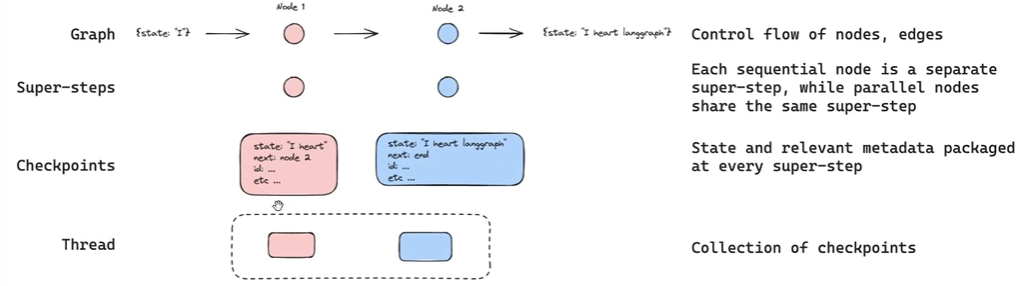

In [16]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image
from langgraph.prebuilt import ToolNode,tools_condition

graph=StateGraph(State)
graph.add_node('llm_node',llm_node)
graph.add_node('tools',ToolNode(tools))

graph.add_edge(START,'llm_node')
# graph.add_edge('llm_node',END) # here we can skip this
graph.add_conditional_edges('llm_node',tools_condition)
# edge from tools to perform observe 
graph.add_edge('tools','llm_node')

to add memory, we need to pass MemorySaver object while compiling the graph

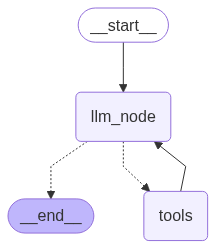

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()
graph_memory=graph.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [18]:
# specify the thread, assume each thread as a different user having particular configurations
# provide unique thread id for each user
config={"configurable":{'thread_id':'user1'}}

In [19]:
results=graph_memory.invoke({'messages':'what is 12 plus 2'},config=config)
for result in results['messages']:
    result.pretty_print()

================================ Human Message =================================

what is 12 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (3gg6a72np)
 Call ID: 3gg6a72np
  Args:
    a: 12
    b: 2
================================= Tool Message =================================
Name: add

14
================================== Ai Message ==================================

The result of the function call is 14.


In [20]:
results=graph_memory.invoke({'messages':'multiply by 2'},config=config)
for result in results['messages']:
    result.pretty_print()

================================ Human Message =================================

what is 12 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (3gg6a72np)
 Call ID: 3gg6a72np
  Args:
    a: 12
    b: 2
================================= Tool Message =================================
Name: add

14
================================== Ai Message ==================================

The result of the function call is 14.
================================ Human Message =================================

multiply by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (tphm72ygq)
 Call ID: tphm72ygq
  Args:
    a: 14
    b: 2
================================= Tool Message =================================
Name: multiply

28
================================== Ai Message ==================================

The result of the function call is 28.


## Streaming
Methods: *.stream()* and *astream()*
- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state
- **values:** this stream the full state of the graph after each node is called
- **updates:** default, this streams updates to the state of the graph after each node is called

In [26]:
# create thread 2
config2={'configurable':{'thread_id':'user2'}}

for chat in graph_memory.stream({'messages':'what is 2 plus 2'},config=config2,stream_mode='values'):
    print(chat)

{'messages': [HumanMessage(content='what is 2 plus 2', additional_kwargs={}, response_metadata={}, id='dedafb56-49a4-42a8-ab69-f4e19beed1a6')]}
{'messages': [HumanMessage(content='what is 2 plus 2', additional_kwargs={}, response_metadata={}, id='dedafb56-49a4-42a8-ab69-f4e19beed1a6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9jrr7yvg5', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 693, 'total_tokens': 711, 'completion_time': 0.021193373, 'prompt_time': 0.045365931, 'queue_time': 0.051945239, 'total_time': 0.066559304}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5a11dac2-6797-4165-87c8-42e19a00e851-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': '9jrr7yvg5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 693

#### astream method
- Streaming tokens we often want to stream more than graph state.
- In particular, with chat model calls it is common to stream the tokens as they are generated.
- We can do this using the *.astream_events()* method, which streams back events as they happen inside nodes.
- Each event is a dict with a few keys:
    - **event:** this is the types of event that is being emitted
    - **name:** this is the name of event.
    - **data:** this is the data associated with the event
    - **metadata:** Containslanggraph_node, the node emitting the event.

In [ ]:
config3={'configurable':{'thread_id':'user3'}}

async for event in graph_memory.astream_events({'messages':'2 plus 2'},config=config3,version='v2'):
    print(event)

## Debugging

To debug the entire workflow of graph:
- install library *langgraph-cli[inmem]*
- create and keep all the related files inside a folder
- have the agent code in some.py file
- IMP: have one langgraph.json file, which will have some configurations:
    - dependencies: ['.'], here dot means whatever is present in same folder consider all those as dependency
    - inside graphs, we can have any name of our agent as key and value should point to file in which will have the graph code along with : separated agent(final graph after compile) name
    - env points to .env file 
- to run the code and debug in langgraph studio, run command *langgraph dev*, it will route to langsmith langgraph studio 

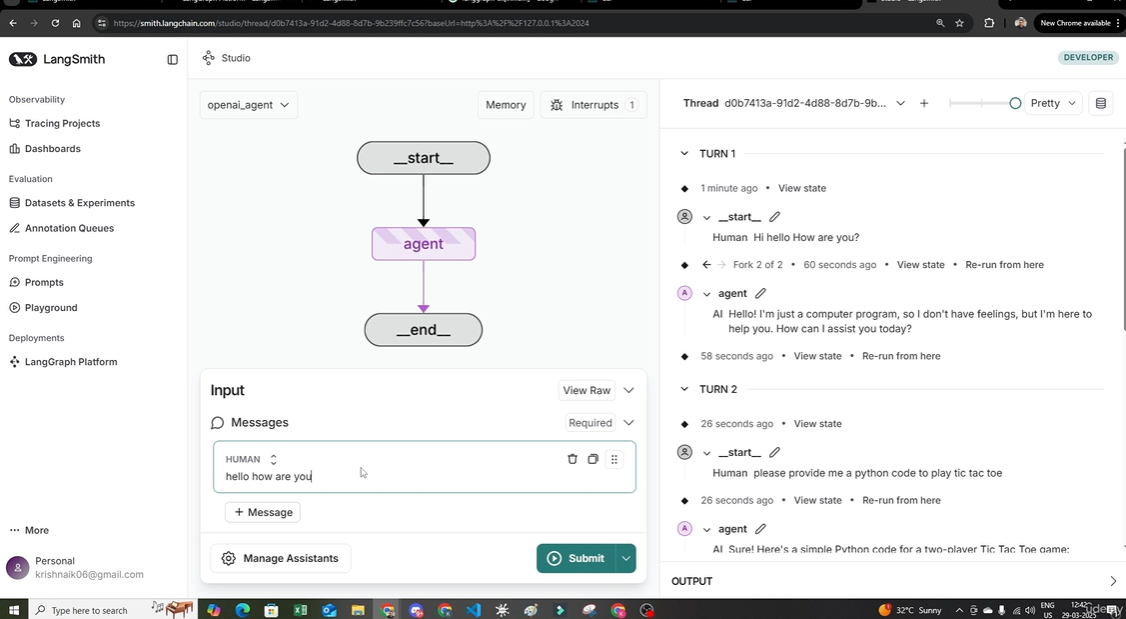

In [ ]:
# langgraph.json file content
{
    "dependencies":["."],
    "graphs":{
        "openai_agent":"./openai_agent.py:agent"
    },
    "env":"../.env"
}